### Bayesian Methods - Bayesian Logistic Regression

Using six features (seven including constant) we are to classify whether or not a woman is working or not. This is done by logistic regression, in which the weighting parameters follow some prior distribution, in the Bayesian approach. Recall, in logistic regression we are trying to find parameters $\mathbf{w}$ for the features which are then parsed into the Sigmoid function.

$$
\sigma(z) \triangleq \frac{1}{1-e^{-z}}
$$

$$
\mathbb{P}(Y_i = 1 | \mathbf{x}, \mathbf{w}) = \sigma(\mathbf{w}^{\text{T}}\mathbf{x})
$$

The prior is set to:
$$
\mathbf{w} \sim N(\mathbf{0}, \tau^2\mathbf{I}_7)
$$

With the likelihood function being:

$$
p(\mathcal{D}|\mathbf{w}) = \prod_{(\mathbf{x}, y) \in \mathcal{D}} [\sigma(\mathbf{w}^{\text{T}}\mathbf{x})]^y [1-\sigma(\mathbf{w}^{\text{T}}\mathbf{x})]^{1-y}
$$

And the posterior distribution having the form derived from Bayes' rule:
$$
p(\mathbf{w}|\mathcal{D}) = \frac{p(\mathcal{D}|\mathbf{w})p(\mathbf{w})} {p(\mathbf{\mathcal{D}})}
$$

Where the evidence is calculated as:
$$
p(\mathbf{\mathcal{D}}) = \underset{}{\int_{\mathbb{R}} \cdots \int_{\mathbb{R}}} \prod_{(\mathbf{x}, y) \in \mathcal{D}} [\sigma(\mathbf{w}^{\text{T}}\mathbf{x})]^y [1-\sigma(\mathbf{w}^{\text{T}}\mathbf{x})]^{1-y}p(\mathbf{w})~dw_1\cdots dw_7
$$


The prior distribution is non-conjugate. In addition, there exists no closed-form expression of the posterior distribution, which is easy to see, since Bayes' factor is computationally intractable to calculated due to the curse of high dimensionality.
##### Laplace Approximation
However, for large samples sizes, we can normally approximate the posterior distribution. Then it is simple to find samples from the posterior. This is also called **Laplace Approximation**.

The approximation has the form:
$$
\mathbf{w}|\mathcal{D} \sim N(\mathbf{w}_{\text{MAP}}, -\nabla^2\ln(p(\mathbf{w}_{\text{MAP}}|\mathcal{D})))
$$


We can arrive at the posterior normal approximation by Taylor expanding the posterior distribution around $\mathbf{w}_{\text{MAP}}$. There are two paths forward. (i) is to calculate the Taylor approximation of the log posterior by hand (requiring the usage of the likelihood function and prior). (ii) is to find the $\mathbf{w}_{\text{MAP}}$ numerically with some optimzation algorithm, by maximizing the likelihood times the prior.

In [482]:
import pandas as pd
import numpy as np 

from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

In [441]:
# Data import. 
df = pd.read_csv('data/WomenAtWork.dat', delimiter='\t', engine='python')
df

,Work,Constant,HusbandInc,EducYears,ExpYears,Age,NSmallChild,NBigChild
0,1.0,1.0,22.394940,12.0,7.0,43.0,0.0,3.0
1,0.0,1.0,7.232000,8.0,10.0,34.0,0.0,7.0
2,1.0,1.0,18.271990,12.0,4.0,41.0,1.0,5.0
3,0.0,1.0,28.069000,14.0,2.0,43.0,0.0,2.0
4,1.0,1.0,7.799889,12.0,10.0,31.0,0.0,1.0
...,...,...,...,...,...,...,...,...
163,1.0,1.0,25.075040,12.0,9.0,43.0,0.0,3.0
164,1.0,1.0,27.799960,17.0,8.0,54.0,0.0,0.0
165,0.0,1.0,20.200000,13.0,7.0,53.0,0.0,0.0
166,0.0,1.0,42.250000,12.0,3.0,30.0,1.0,1.0


In [463]:
def sigmoid(x: np.array) -> np.array:
    return np.exp(x) / (1 + np.exp(x))

In [443]:
def log_likelihood(X: np.array, t: np.array, w: np.array) -> float:
    epsilon = 1e-3
    prob = sigmoid(X @ w)
    likelihood_vector = t @ np.log(prob + epsilon) + (1 - t) @ np.log(1 - prob + epsilon)
    return np.sum(likelihood_vector)

In [444]:
from scipy.stats import multivariate_normal


def log_prior(w: np.array, init_sigma: float) -> float:
    epsilon = 1e-3
    mean = np.zeros(len(w))
    covariance_matrix = init_sigma * np.identity(len(w))
    return np.log(multivariate_normal.pdf(w, mean, covariance_matrix) + epsilon)

In [445]:
def objective(w: np.array, X: np.array, t: np.array, init_sigma: float) -> float:
    return -(log_likelihood(X, t, w) + log_prior(w, init_sigma=init_sigma))

In [459]:
from scipy.optimize import minimize

# Stable initial solution.
x0 = np.array(
[-1.7012604510755014,
 -1.1196676407493864,
 2.639602500390759,
 1.088785147860549,
 0.3254163608102913,
 3.4308174226161103,
 1.8217426564308559]
 )

# Parameters.
X = df[df.columns[1:]]
X = np.array(X)

t = df[df.columns[0]]
t = np.array(t)
init_sigma = 5


# Optimization results.
solution  = minimize(objective, x0=x0, args=(X, t, init_sigma))

# MAP weights
w_map = solution.x

# Inverse Hessian
inv_hessian = solution.hess_inv

In [475]:
def simulate_posterior(x: np.array, mean: np.array, covariance_matrix: np.array) -> np.array:
    w = multivariate_normal.rvs(mean, covariance_matrix)
    return sigmoid(x.T @ w) 

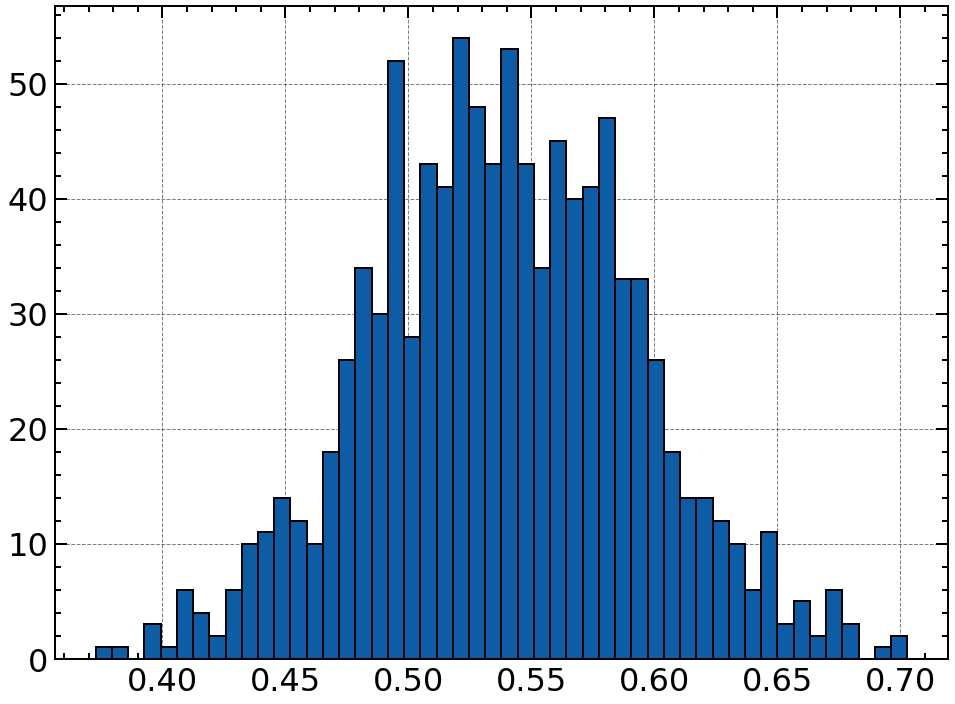

In [483]:
# Testing posterior simulation.
NUMBER_OF_SIMULATIONS = 1000
prob_list = []
x = np.array([1, 20, 12, 8, 43, 0, 2])
for _ in range(NUMBER_OF_SIMULATIONS):
    prob_list.append(simulate_posterior(x, w_map, -inv_hessian))

plt.hist(prob_list, bins=50, edgecolor='black')
plt.show()